##### Case Fraude
Essa base de dados apresenta dados através dos quais será possível realizar uma análise e criação de modelo para detecção de fraudes em cartões de crédito.

Sabe-se que fraudes em cartões de crédito podem gerar grandes prejuízos, além de frutração a clientes. Sendo assim, possuir um modelo que tenha uma taxa de erro baixa é importante para evitar prejuízos e o churn.

Informações sobre a base:

- score_1 a score_10: São notas de bureau de crédito que a empresa adquiriu para identificar se o comprador é confiável ou outros dados anonimizados que não temos informação sobre

- País: pais de compra

- Produto: produto que está sendo comprado no e-commerce

- Categoria_produto: categoria a qual esse produto se encaixa

 - Entrega_doc_1 a entrega_doc_3: Documentos requisitados no momento de fazer a conta. 0 = N = nao entregou. Y = 1 = entregou. Se vazio, considere que nao entregou

- Score_fraude_modelo: score dado pelo modelo atual. É a probabilidade daquela compra ser uma fraude ou nao. Quanto mais próximo de 100, maior a certeza do modelo que é fraude

- Fraude: informacao se aquela compra era fraudulenta ou nao. Foi inserida após alguns dias, para termos o feedback real se de fato era fraudulenta ou nao. 0 se nao era fraudulenta e 1 se era fraudulenta

In [1]:
# importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce

In [2]:
df = pd.read_excel(r'c:/Users/carol/Downloads/dados.xlsx')
df.head(3)

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   score_1              150000 non-null  int64         
 1   score_2              137016 non-null  float64       
 2   score_3              137016 non-null  float64       
 3   score_4              149635 non-null  float64       
 4   score_5              150000 non-null  float64       
 5   score_6              149989 non-null  float64       
 6   pais                 149806 non-null  object        
 7   score_7              150000 non-null  int64         
 8   produto              150000 non-null  object        
 9   categoria_produto    150000 non-null  object        
 10  score_8              150000 non-null  float64       
 11  score_9              149989 non-null  float64       
 12  score_10             149635 non-null  float64       
 13  entrega_doc_1 

In [4]:
df.describe()

,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,entrega_doc_1,valor_compra,score_fraude_modelo,fraude
count,150000.000000,137016.000000,1.370160e+05,149635.000000,150000.000000,149989.000000,150000.000000,150000.000000,149989.000000,149635.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,3.705407,0.728115,2.604451e+05,21.677669,0.220641,51.169352,14.193513,0.497532,2305.409403,299.969579,0.902353,43.523134,48.066240,0.050000
std,0.753206,0.132943,8.464361e+05,20.062146,2.434995,709.472904,14.161216,0.288348,1712.379601,321.075806,0.296837,91.557888,28.995122,0.217946
min,1.000000,0.000000,1.600000e-01,0.000000,0.000000,-5.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,4.000000,0.678400,9.679915e+03,2.000000,0.000000,1.000000,3.000000,0.246819,910.000000,42.000000,1.000000,9.380000,23.000000,0.000000
50%,4.000000,0.755500,4.371165e+04,14.000000,0.104875,8.000000,9.000000,0.495990,1937.000000,193.000000,1.000000,20.610000,48.000000,0.000000
75%,4.000000,0.806500,1.454436e+05,50.000000,0.282938,33.000000,21.000000,0.746508,3445.000000,459.000000,1.000000,40.692500,73.000000,0.000000
max,4.000000,1.000000,1.387874e+07,50.000000,833.333333,145274.000000,58.000000,0.999995,7544.000000,2225.000000,1.000000,3696.350000,100.000000,1.000000


In [5]:
# describe das categóricas
df.describe(exclude='number')

,pais,produto,categoria_produto,entrega_doc_2,entrega_doc_3,data_compra
count,149806,150000,150000,41143,150000,150000
unique,51,127804,8324,2,2,145813
top,BR,Fone De Ouvido Sem Fio Xiaomi Airdots Preto,cat_43b9c10,Y,Y,2020-03-19 15:30:23
freq,111628,83,2331,24091,83129,4
first,NaN,NaN,NaN,NaN,NaN,2020-03-08 00:02:15
last,NaN,NaN,NaN,NaN,NaN,2020-04-21 23:59:56


In [6]:
# visualizando o tamanho da base
df.shape

(150000, 20)

In [7]:
#visualizando os duplicados
df.duplicated().sum()

0

In [8]:
# porcentagem de itens nulos por coluna
(df.isnull().sum()/df.shape[0]*100).round(2)

score_1                 0.00
score_2                 8.66
score_3                 8.66
score_4                 0.24
score_5                 0.00
score_6                 0.01
pais                    0.13
score_7                 0.00
produto                 0.00
categoria_produto       0.00
score_8                 0.00
score_9                 0.01
score_10                0.24
entrega_doc_1           0.00
entrega_doc_2          72.57
entrega_doc_3           0.00
data_compra             0.00
valor_compra            0.00
score_fraude_modelo     0.00
fraude                  0.00
dtype: float64

Podemos ver que a coluna 'entrega_doc_2' possui uma grande quantidade de valores nulos, 72,57%

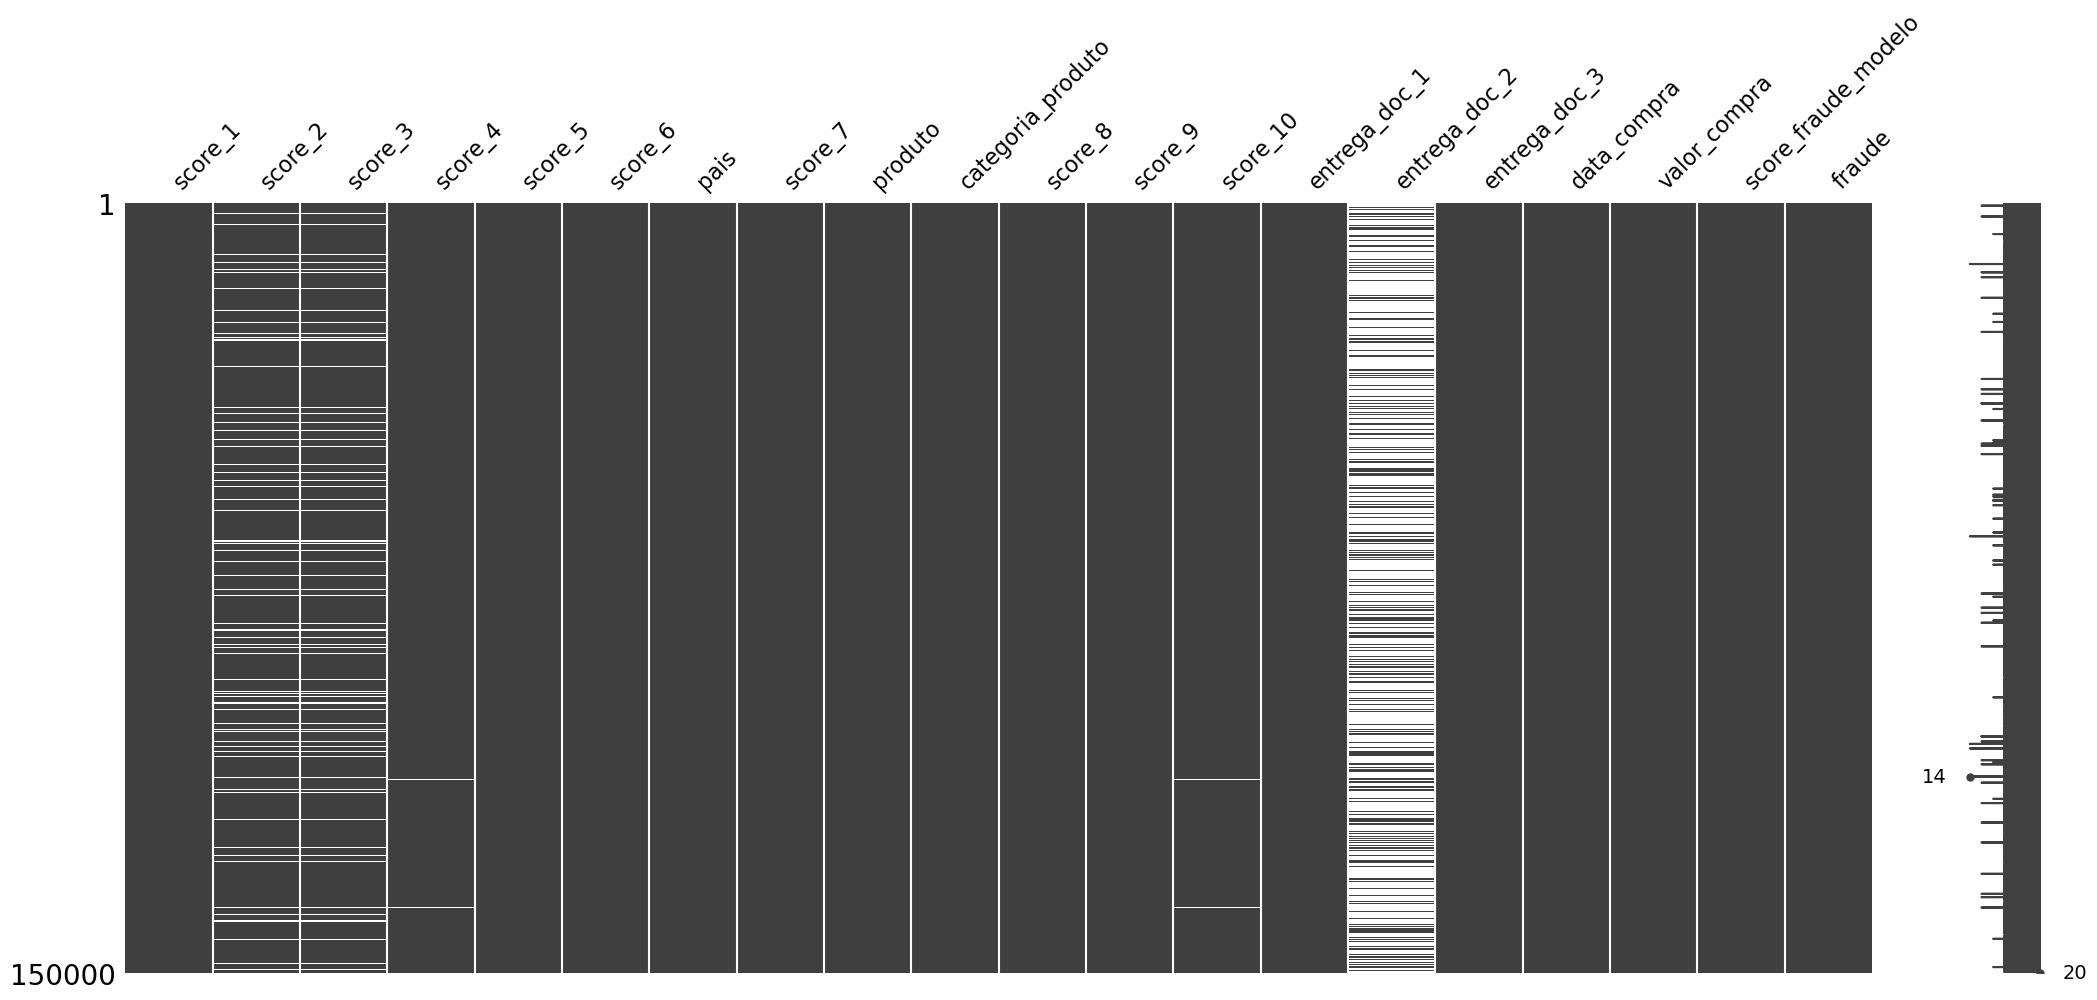

In [9]:
# visualizando de forma gráfica
msno.matrix(df);

A partir desse gráfico conseguimos visualizar de maneira mais clara a quantidade de dados faltantes em cada coluna, sobressaindo a coluna "entrega_doc_2", sendo que os valores nulos podem representar a não entrega de documentos, o que pode estar relacionado a possíveis fraudadores.

In [10]:
# visualizando a coluna 'pais'
df.pais.value_counts().head(10)

BR    111628
AR     31964
UY      2967
US      2273
SE       358
MX       236
RU        73
ES        69
CO        64
GB        43
Name: pais, dtype: int64

Os países com maio número de fraudes são Brasil e Argentina para essa base

In [11]:
#visualizando com porcentagem
(df.pais.value_counts()/df.shape[0]*100).round(2).head(15)

BR    74.42
AR    21.31
UY     1.98
US     1.52
SE     0.24
MX     0.16
RU     0.05
ES     0.05
CO     0.04
GB     0.03
FR     0.01
IT     0.01
PT     0.01
DE     0.01
CL     0.01
Name: pais, dtype: float64

In [12]:
# quantos países há na base?
len(df.pais.unique())

52

In [13]:
#verificando fraudes em cada país
paises = ((df.pais.loc[df.fraude == 1].value_counts()/df.loc[df.fraude == 1].shape[0])*100).round(2)
paises

BR    82.16
AR    15.72
US     0.93
UY     0.39
SE     0.20
RU     0.08
ES     0.07
MX     0.04
FR     0.04
DE     0.04
EC     0.03
NL     0.03
KR     0.01
CO     0.01
NZ     0.01
FI     0.01
CL     0.01
PT     0.01
Name: pais, dtype: float64

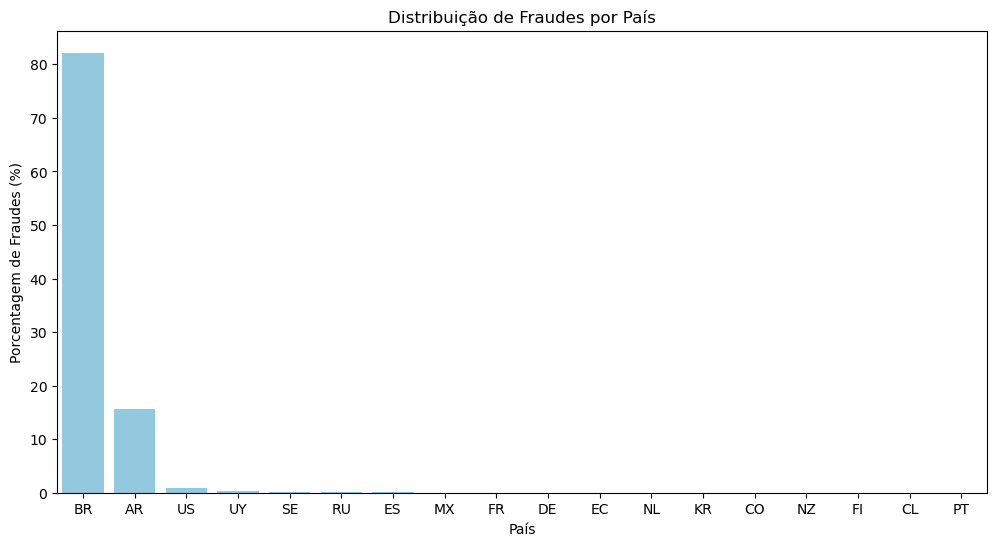

In [14]:
# Criando um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=paises.index, y=paises.values, color='skyblue')
plt.title('Distribuição de Fraudes por País')
plt.xlabel('País')
plt.ylabel('Porcentagem de Fraudes (%)')
plt.show()

In [15]:
# verificando a coluna 'produto'
df.produto.value_counts()

Fone De Ouvido Sem Fio Xiaomi Airdots Preto                     83
Xiaomi Redmi Note 8 Dual Sim 64 Gb Azul-netuno 4 Gb Ram         51
Clean Sept - Álcool Em Gel 70% 500 Ml                           49
Tapete Ilustrativo Pista Carrinho Hot Wheels 0,60x1,20m         47
Máscara Descartável Tripla Com Elástico Proteção Anvisa 50un    47
                                                                ..
Bateria Zetta, Nova, Com Nota Fiscal, 12 Mês De Garantia         1
Dispenser Jabón Liquido / Alcohol En Gel X Unidad                1
Moletom Gola Redonda Shawn Mendes Top 98 Unissex Promoção        1
Placa Interface Adesivo Lavadora Brastemp Bwl11 Emicol Biv.      1
A Magia Divina Das Velas. O Livro Das Sete Chamas Sagradas       1
Name: produto, Length: 127804, dtype: int64

In [16]:
# visualizando o número de produtos
len(df.produto.unique())

127804

In [17]:
# visualizando as categorias
len(df['categoria_produto'].unique())

8324

In [18]:
# visualizando as categorias existentes
df['categoria_produto'].value_counts().head(10)

cat_43b9c10    2331
cat_d69bed9    1799
cat_604df77    1784
cat_6c4cfdc    1449
cat_4249bd8    1191
cat_3203c7c    1093
cat_be0af8e    1040
cat_0820fab     938
cat_8ef7164     909
cat_d5975ae     878
Name: categoria_produto, dtype: int64

In [19]:
# visualizando a coluna ' valor_compra'
df['valor_compra'].describe()

count    150000.000000
mean         43.523134
std          91.557888
min           0.020000
25%           9.380000
50%          20.610000
75%          40.692500
max        3696.350000
Name: valor_compra, dtype: float64

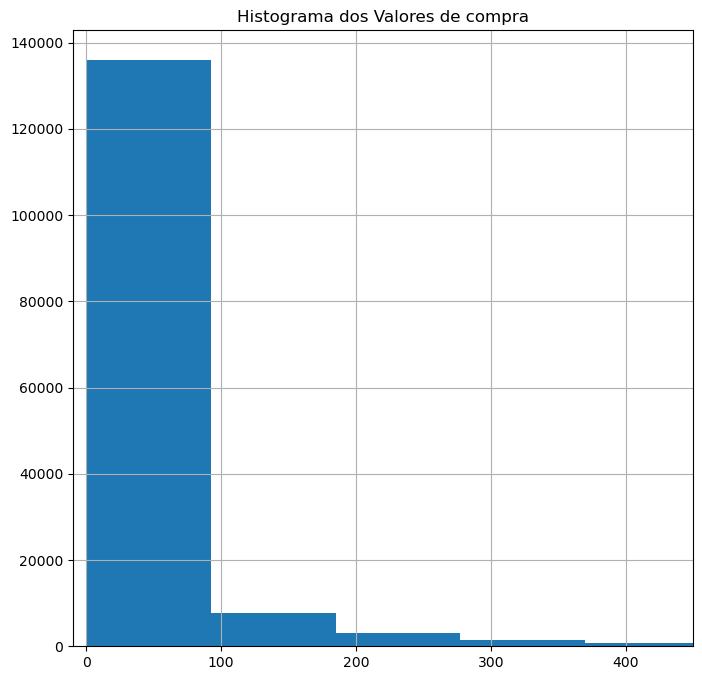

In [20]:
#histograma da coluna 'valor_compra'

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Histograma dos Valores de compra')
ax.set_xlim(-10, 450)
df.valor_compra.hist(ax = ax, bins = 40)
fig.show();

In [21]:
#verificando as fraudes
fraude = df.fraude.value_counts()
display(fraude)

0    142500
1      7500
Name: fraude, dtype: int64

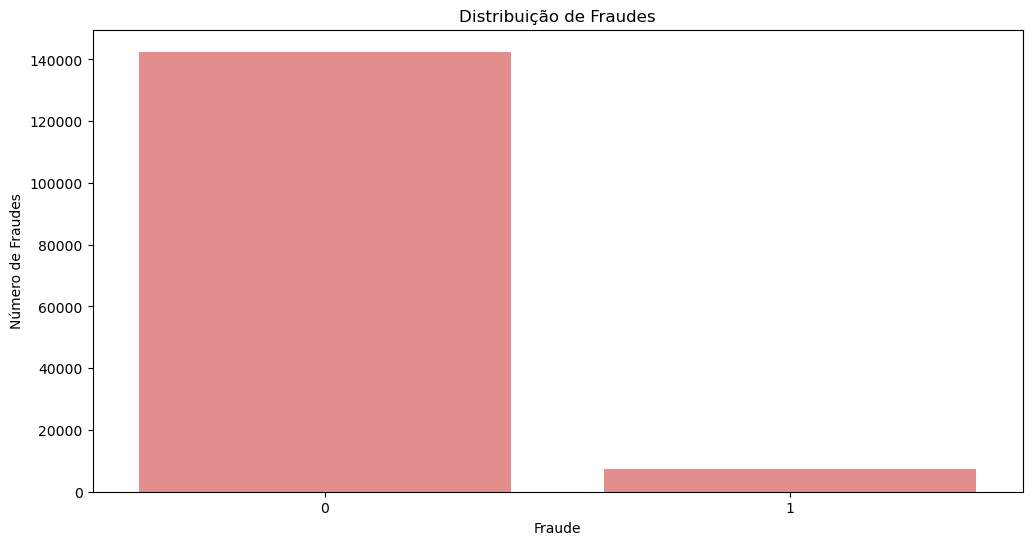

In [22]:
# Criando um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=fraude.index, y=fraude.values, color='lightcoral')
plt.title('Distribuição de Fraudes')
plt.xlabel('Fraude')
plt.ylabel('Número de Fraudes')
plt.show()

##### Verificando as entregas dos documentos

In [23]:
doc1 = df['entrega_doc_1'].value_counts()
doc1

1    135353
0     14647
Name: entrega_doc_1, dtype: int64

In [24]:
doc2 = df['entrega_doc_2'].value_counts()
doc2

Y    24091
N    17052
Name: entrega_doc_2, dtype: int64

In [25]:
doc3 = df['entrega_doc_3'].value_counts()
doc3

Y    83129
N    66871
Name: entrega_doc_3, dtype: int64

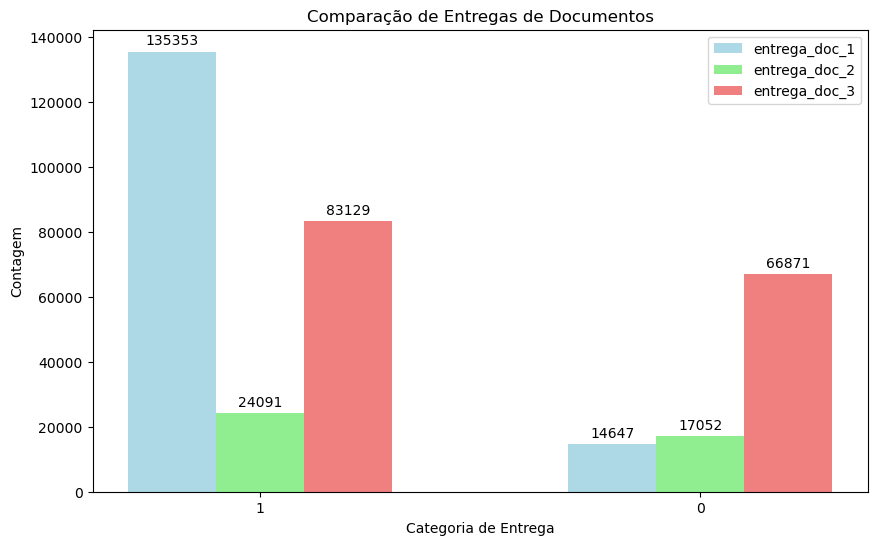

In [26]:
# Criando um gráfico de barras agrupadas com rótulos
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2
indices = np.arange(len(doc1))

bar1 = ax.bar(indices - width, doc1, width=width, color='lightblue', label='entrega_doc_1')
bar2 = ax.bar(indices, doc2, width=width, color='lightgreen', label='entrega_doc_2')
bar3 = ax.bar(indices + width, doc3, width=width, color='lightcoral', label='entrega_doc_3')

# Adicionando rótulos nas barras
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

# Configurando detalhes do gráfico
ax.set_title('Comparação de Entregas de Documentos')
ax.set_xlabel('Categoria de Entrega')
ax.set_ylabel('Contagem')
ax.set_xticks(indices)
ax.set_xticklabels(doc1.index)
ax.legend()

plt.show()

Esse gráfico nos ajuda a visualizar que o doc1 foi o mais entregue e o doc2, o menos entregue

##### Histograma das colunas Score

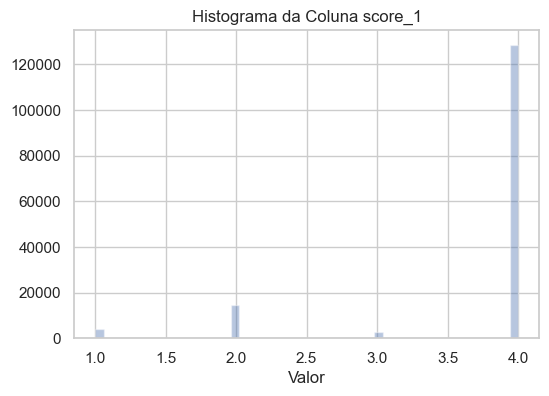

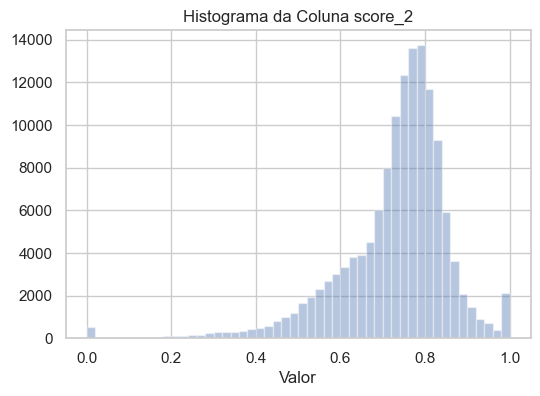

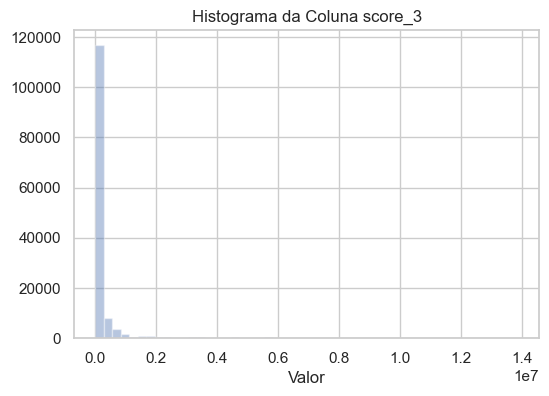

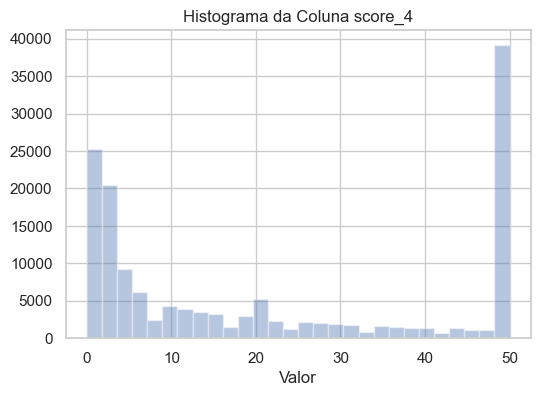

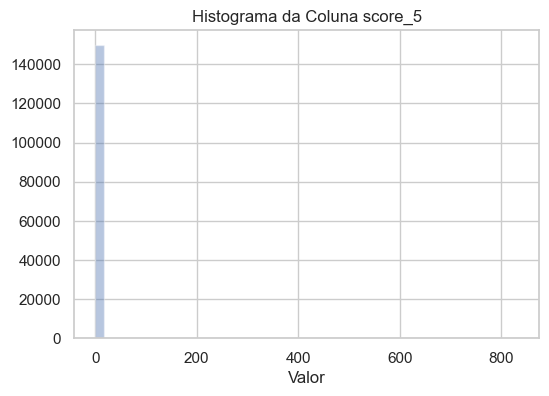

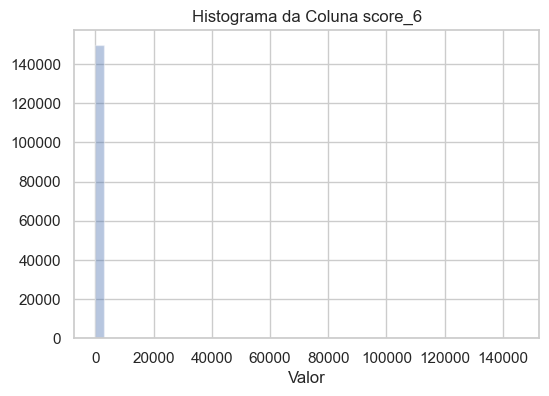

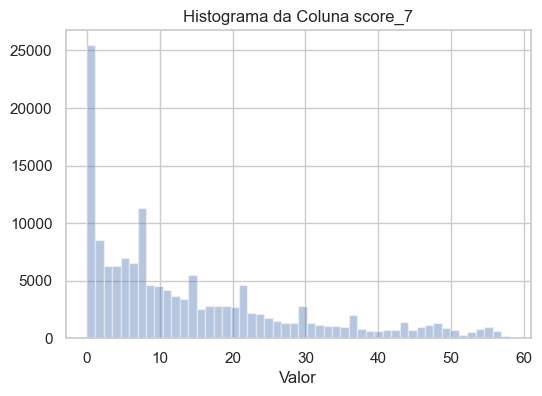

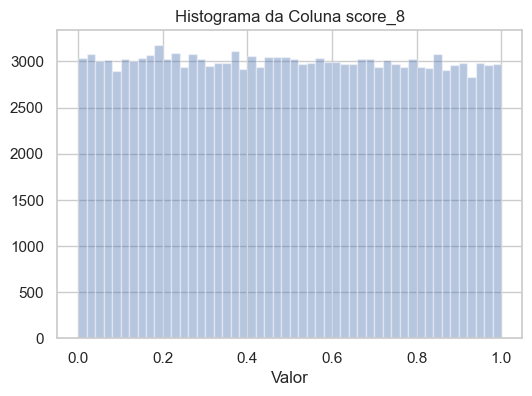

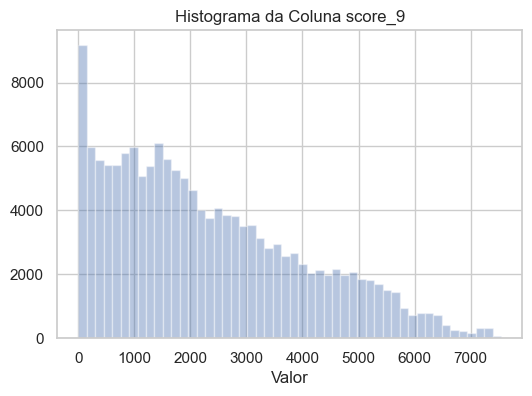

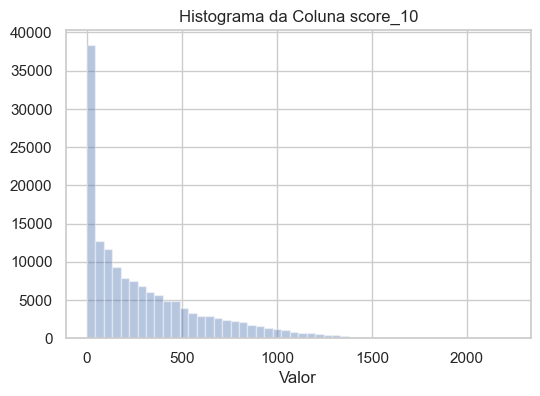

In [27]:
colunas_score = ['score_1','score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']

sns.set(style='whitegrid')

# criando um histograma pra cada coluna 'score'
for coluna in colunas_score:
    plt.figure(figsize=(6, 4))
    plt.title(f'Histograma da Coluna {coluna}')
    sns.distplot(df[coluna], kde=False)
    plt.xlabel('Valor')
    plt.show()

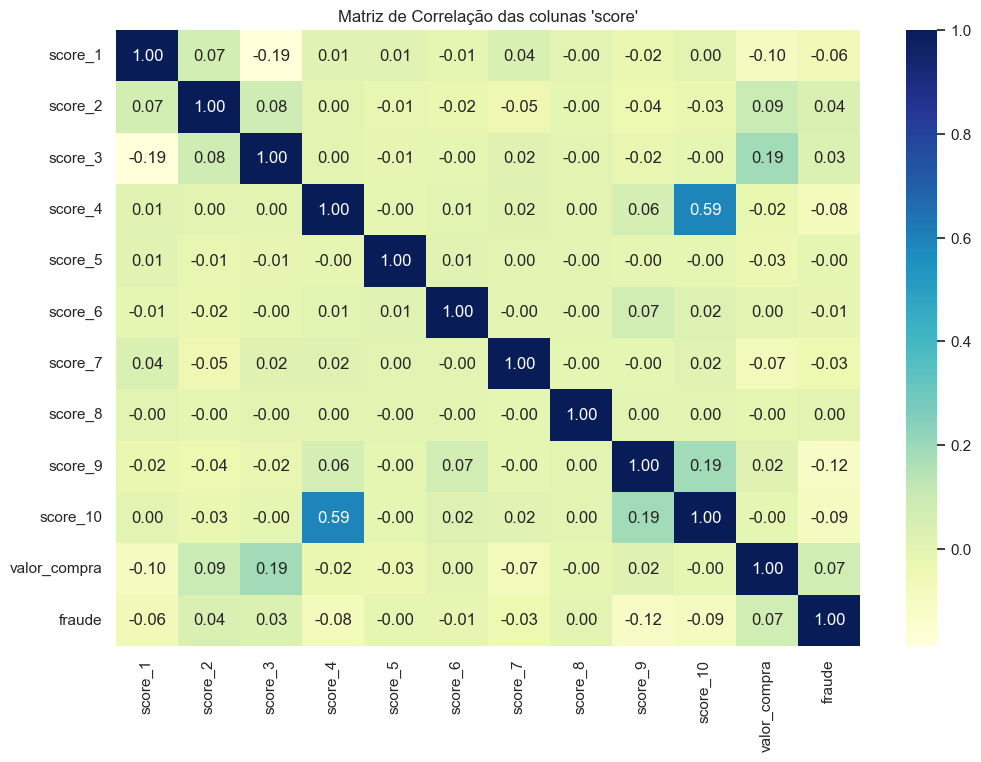

In [28]:
# verificando a correlação entre as colunas 'score'
corr = df[['score_1','score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10', 'valor_compra', 'fraude']].corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr, annot = True, cmap = "YlGnBu", fmt = ".2f" )
plt.title("Matriz de Correlação das colunas 'score'")
plt.show()

Podemos visualizar que há uma correlação moderada entre as colunas 'score_4' e 'score_10' de 0,59.

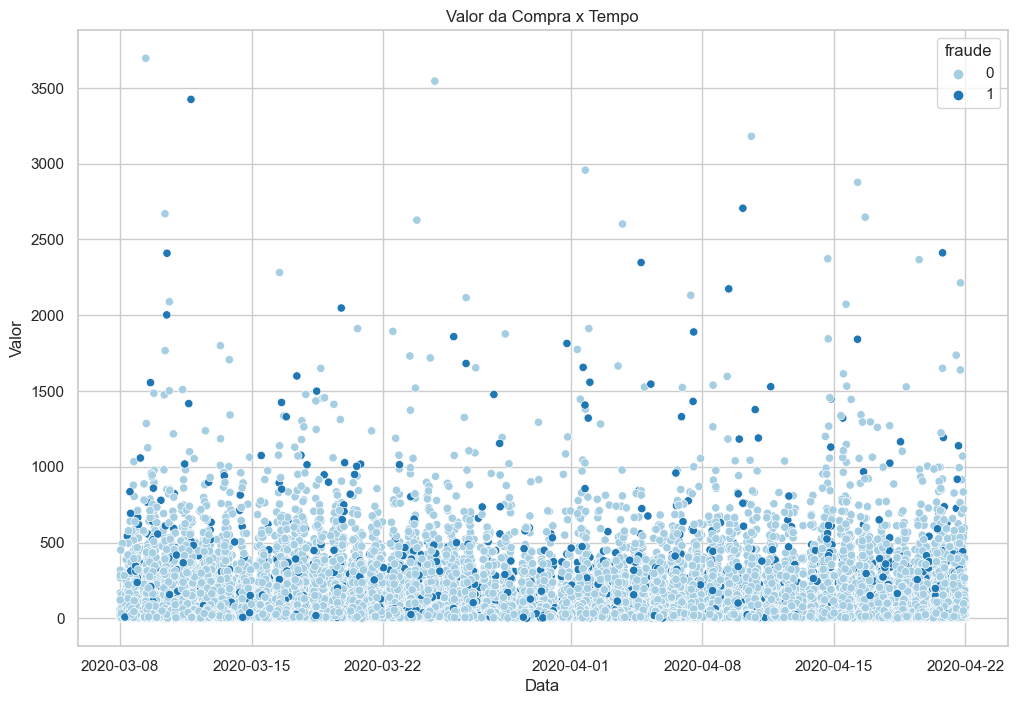

In [29]:
#verificando se há relação entre 'data_compra' e o 'valor'

plt.figure(figsize=(12,8))

sns.scatterplot(x = 'data_compra', y = 'valor_compra', 
                hue = 'fraude', data = df, palette='Paired')
plt.title('Valor da Compra x Tempo')
plt.xlabel('Data')
plt.ylabel('Valor')

plt.show()

O gráfico não nos permite inferir alguma relação entre as duas features

- Para incluir novas colunas seria interessante criar uma cópia do dataset, a fim de não alterar o dataset original, porém não irei realizar essa etapa apenas para usar menos memória

In [30]:
# adicionando novas colunas 
df['dia'] = df['data_compra'].dt.day

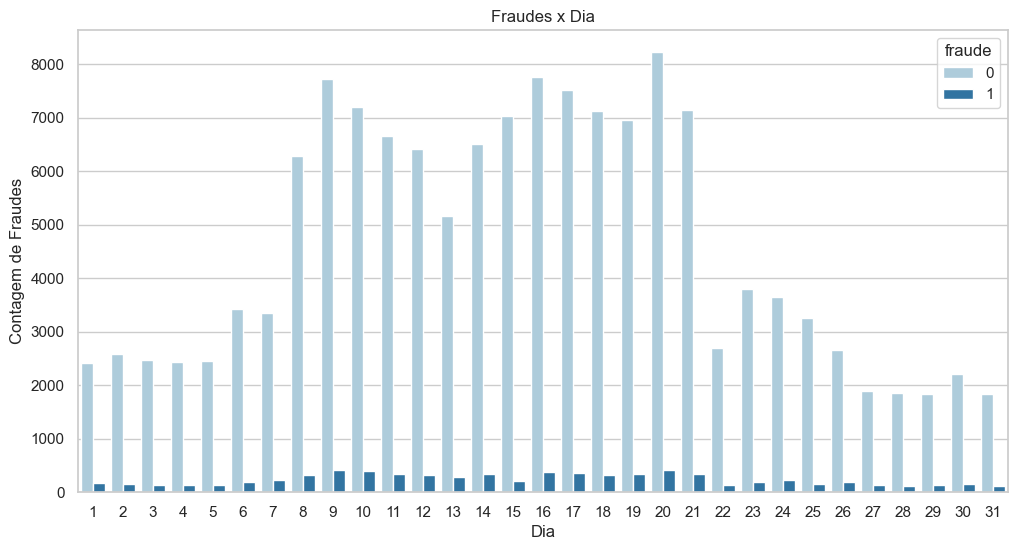

In [31]:
#plotando o gráfico

plt.figure(figsize=(12,6))
sns.countplot(x = 'dia', hue = 'fraude',data = df, palette= 'Paired')

plt.title('Fraudes x Dia')
plt.xlabel('Dia')
plt.ylabel('Contagem de Fraudes')

plt.show()

- Para verificar se realmente há relação entre o dia e fraude, iremos realizar testes estatísticos.

In [32]:
#utilizando t de Student

test1 = df['dia']
test2 = df['fraude']

t_statistics, p_value = stats.ttest_ind(test1, test2)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


- iremos realizar o mesmo para mês e hora

In [33]:
# adicionando novas colunas - mês
df['mês'] = df['data_compra'].dt.month

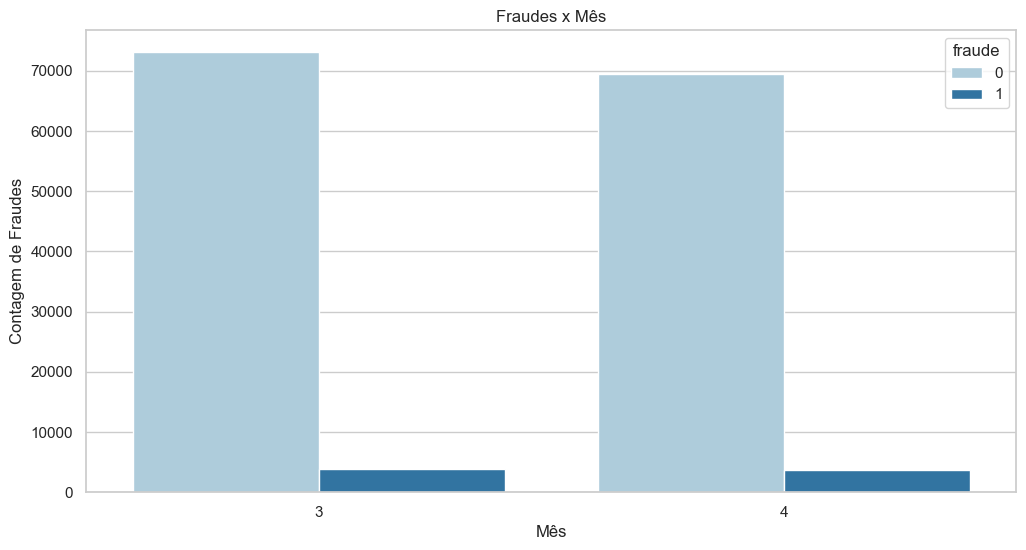

In [34]:
#plotando o gráfico

plt.figure(figsize=(12,6))
sns.countplot(x = 'mês', hue = 'fraude',data = df, palette= 'Paired')

plt.title('Fraudes x Mês')
plt.xlabel('Mês')
plt.ylabel('Contagem de Fraudes')

plt.show()

In [35]:
#utilizando t de Student

test3 = df['mês']
test4 = df['fraude']

t_statistics, p_value = stats.ttest_ind(test3, test4)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


In [36]:
# adicionando novas colunas - hora
df['hora'] = df['data_compra'].dt.hour

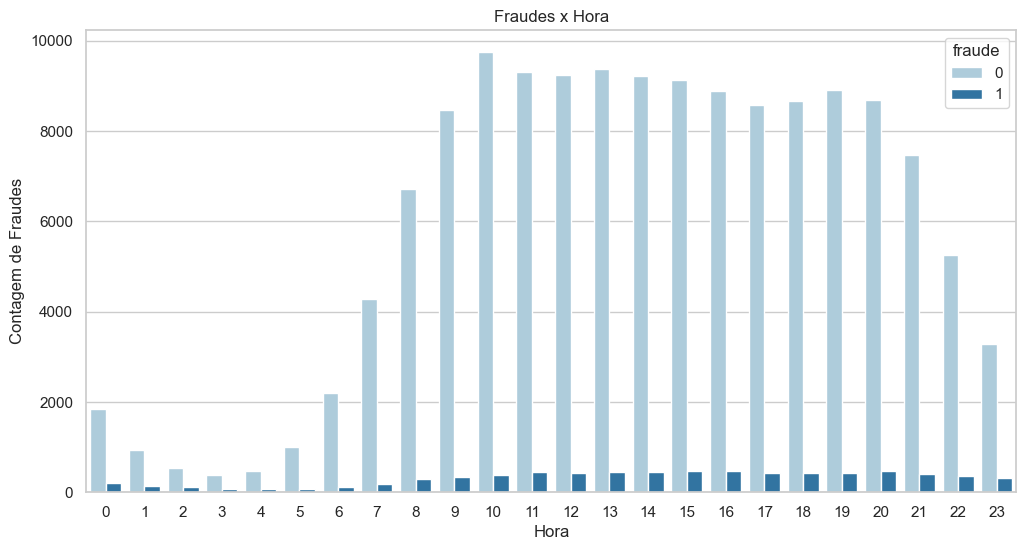

In [37]:
#plotando o gráfico

plt.figure(figsize=(12,6))
sns.countplot(x = 'hora', hue = 'fraude',data = df, palette= 'Paired')

plt.title('Fraudes x Hora')
plt.xlabel('Hora')
plt.ylabel('Contagem de Fraudes')

plt.show()

In [38]:
# verificando se há relação
test_h = df['hora']
test_f = df['fraude']

t_statistics, p_value = stats.ttest_ind(test_h, test_f)

if p_value < 0.05:
    print("Há diferença significativa entre os grupos.")
else:
    print("Não há diferença significativa entre os grupos.")

Há diferença significativa entre os grupos.


##### Verificando relação entre fraude e a entrega de documentos

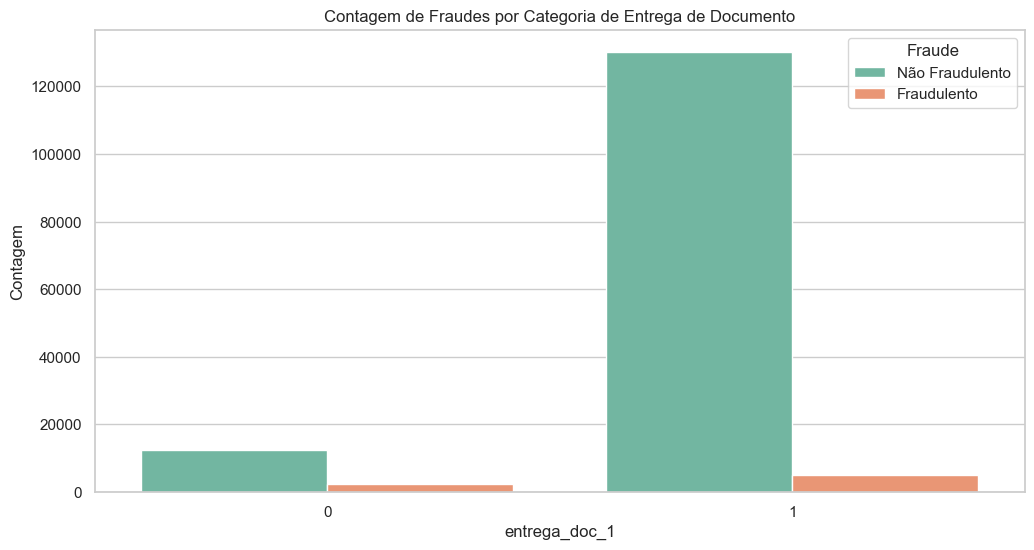

In [39]:
# Criando um gráfico de barras empilhadas - doc1
plt.figure(figsize=(12, 6))

# Gráfico para fraude == 1
sns.countplot(x="entrega_doc_1", hue="fraude", data=df, palette="Set2")

# Configurando detalhes do gráfico
plt.title("Contagem de Fraudes por Categoria de Entrega de Documento")
plt.xlabel("entrega_doc_1")
plt.ylabel("Contagem")
plt.legend(title="Fraude", labels=["Não Fraudulento", "Fraudulento"])
plt.show()

In [40]:
# utilizando qui-quadrado para a coluna 'entrega_doc_2 por conta de termos valores 'float'
contingency_table = pd.crosstab(df["entrega_doc_1"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_1' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'entrega_doc_1' e 'fraude' parecem ser inependentes.")

Valor de chi2: 4217.317158934374
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_1' e 'fraude'.


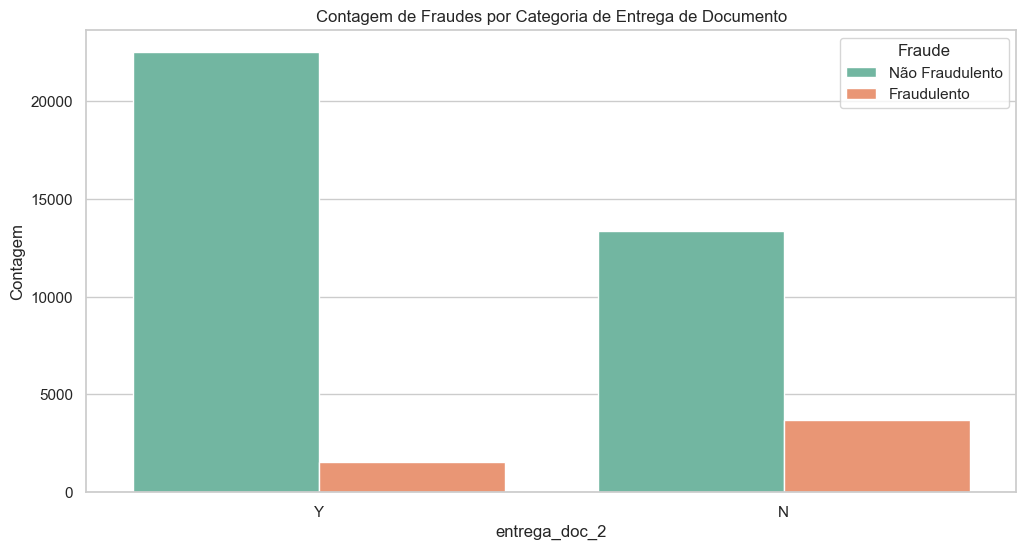

In [41]:
# Criando um gráfico de barras empilhadas - doc2
plt.figure(figsize=(12, 6))

# Gráfico para fraude == 1
sns.countplot(x="entrega_doc_2", hue="fraude", data=df, palette="Set2")

# Configurando detalhes do gráfico
plt.title("Contagem de Fraudes por Categoria de Entrega de Documento")
plt.xlabel("entrega_doc_2")
plt.ylabel("Contagem")
plt.legend(title="Fraude", labels=["Não Fraudulento", "Fraudulento"])
plt.show()

In [42]:
# utilizando qui-quadrado para a coluna 'entrega_doc_2 por conta de termos valores 'float'
contingency_table = pd.crosstab(df["entrega_doc_2"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_2' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'entrega_doc_2' e 'fraude' parecem ser inependentes.")

Valor de chi2: 2093.9742824255336
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_2' e 'fraude'.


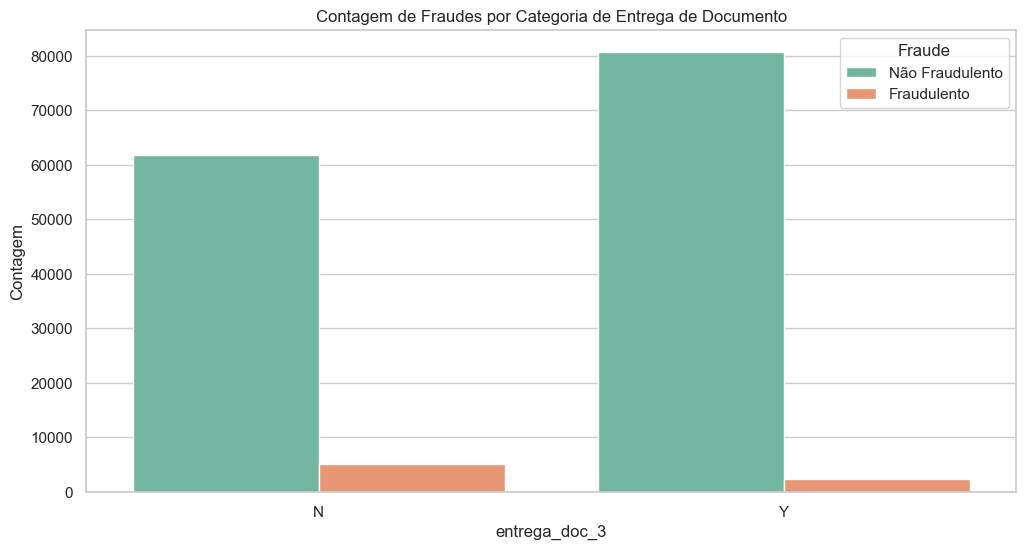

In [43]:
# Criando um gráfico de barras empilhadas - doc3
plt.figure(figsize=(12, 6))

# Gráfico para fraude == 1
sns.countplot(x="entrega_doc_3", hue="fraude", data=df, palette="Set2")

# Configurando detalhes do gráfico
plt.title("Contagem de Fraudes por Categoria de Entrega de Documento")
plt.xlabel("entrega_doc_3")
plt.ylabel("Contagem")
plt.legend(title="Fraude", labels=["Não Fraudulento", "Fraudulento"])
plt.show()

In [44]:
contingency_table = pd.crosstab(df["entrega_doc_3"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_3' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'entrega_doc_3' e 'fraude' parecem ser inependentes.")

Valor de chi2: 1709.9413003678396
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_3' e 'fraude'.


##### Verificamos que as entregas dos documentos têm relação com a fraude e agora iremos verificar se há relação entre os países e fraude.

In [45]:
# visualizando a relação entre país e fraude

contingency_table = pd.crosstab(df["pais"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'pais' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'pais' e 'fraude' parecem ser inependentes.")

Valor de chi2: 435.0414968257157
Valor p: 7.757972296868586e-63
Rejeitamos a hipótese nula. Há uma relação significativa entre 'pais' e 'fraude'.


- entre valor da compra e fraude

In [46]:
# visualizando a relação entre valor da compra e fraude

contingency_table = pd.crosstab(df["valor_compra"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'valor_compra' e 'fraude'.")
else:
     print("Não rejeitamos a hipótese nula. 'valor_compra' e 'fraude' parecem ser inependentes.")

Valor de chi2: 26859.998979289183
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'valor_compra' e 'fraude'.


###### Iremos realizar agora uma avaliação do modelo antigo

- A separação dos dados deve ocorrer antes para que os dados teste não tenham contato com treino e validação

In [47]:
# dividindo os dados em treino e teste
df_train, df_test = train_test_split(df, test_size= 0.2,
                                         random_state= 42)
#separando em X e Y para treino
X_train = df_train.drop('fraude', axis = 1)
y_train = df_train['fraude']

#separando em X e Y para teste
X_test = df_test.drop('fraude', axis = 1)
y_test = df_test['fraude']

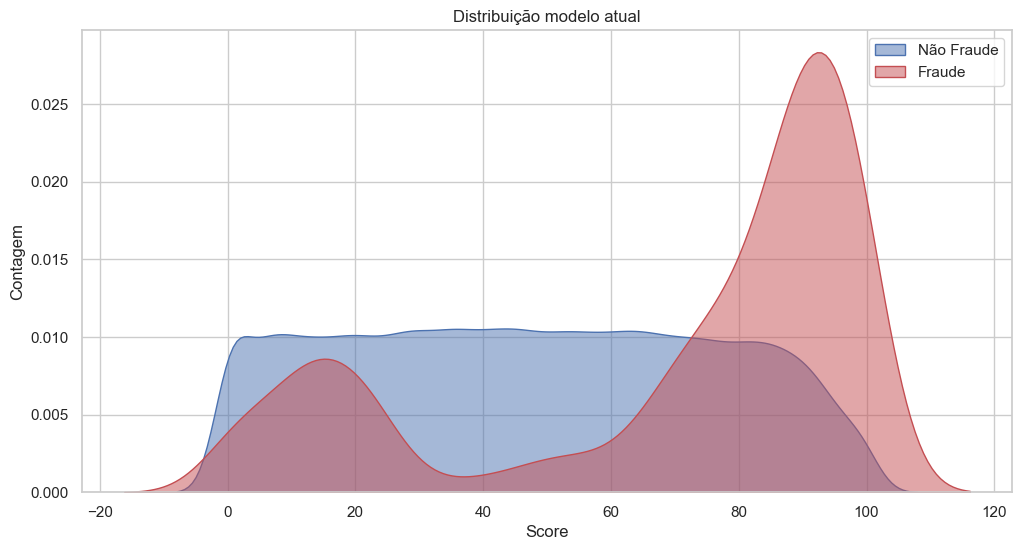

In [48]:
#verificando a distribuição de modelo atual

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.kdeplot(df.loc[lambda base: df.fraude == 0]['score_fraude_modelo'],
            ax=ax, color='b', fill=True, alpha=0.5, label='Não Fraude')
sns.kdeplot(df.loc[lambda base: df.fraude == 1]['score_fraude_modelo'],
            ax=ax, color='r', fill=True, alpha=0.5, label='Fraude')

plt.title('Distribuição modelo atual')
plt.xlabel('Score')
plt.ylabel('Contagem')

ax.legend()

plt.show()

In [49]:
# verificando a partir de métricas
fpr, tpr, thresholds = roc_curve(df['fraude'], df['score_fraude_modelo'])
roc_auc = auc(fpr, tpr)

print('ROC AUC:', roc_auc)


ROC AUC: 0.726275487251462


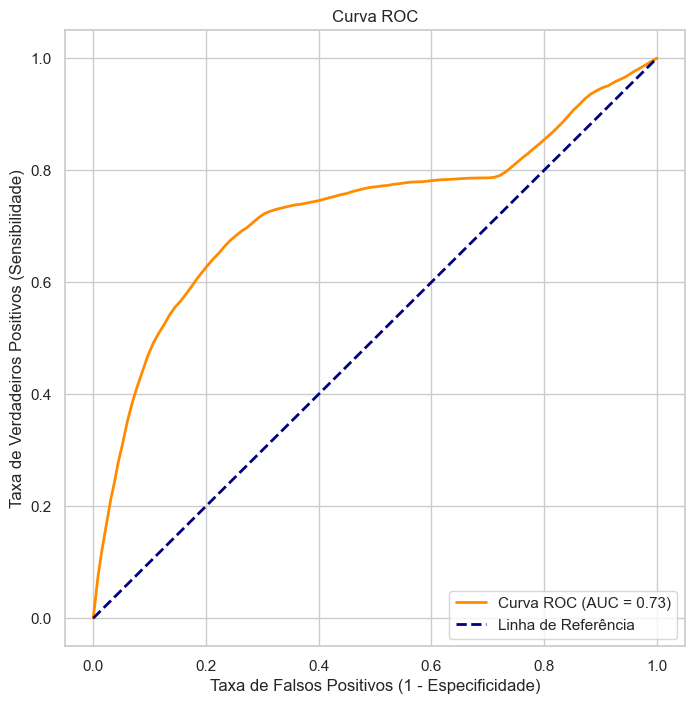

In [50]:
# visualizando a curva ROC 
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Linha de Referência')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Para calcular as receitas, perdas por fraude, lucro e o limiar, criaremos uma função e exibiremos o resultado em uma tabela
- utilizaremos para isso as colunas: 'fraude','score_fraude_modelo','valor_compra' e acoluna criada 'blocked' 

In [51]:
# Definindo variáveis
target_col = "fraude"
prediction_col = "score_fraude_modelo"
amount_col = "valor_compra" 
blocked_col = "blocked"

possible_thresholds = np.arange(1, 100, 1)

# Avaliando diferentes limiares e armazenando resultados em um DataFrame
results = pd.DataFrame()

for threshold in possible_thresholds:
    # Criando uma cópia do DataFrame de teste com a coluna 'blocked' atualizada com base no limiar
    df_test_with_decision = df_test.copy()
    df_test_with_decision[blocked_col] = df_test_with_decision[prediction_col] >= threshold

    # Perdas por fraude, receitas e lucro com base no limiar
    perdas_fraude = ((~df_test_with_decision[blocked_col]) & (df_test_with_decision[target_col])) * df_test_with_decision[amount_col]
    receita = ((~df_test_with_decision[blocked_col]) & (~df_test_with_decision[target_col])) * df_test_with_decision[amount_col] * 0.1
    lucro = receita.sum() - perdas_fraude.sum()

    # Armazenando os resultados no DataFrame
    results = results.append(pd.Series({'Threshold': threshold, 'Perdas por Fraude': perdas_fraude.sum(), 'Receita': receita.sum(), 'Lucro': lucro}), ignore_index=True)

# Exibindo os resultados
display(results)

,Threshold,Perdas por Fraude,Receita,Lucro
0,1.0,1181.23,3242.109,2060.879
1,2.0,1890.99,3917.883,2026.893
2,3.0,1969.12,4829.258,2860.138
3,4.0,2288.36,5726.876,3438.516
4,5.0,2692.96,6743.685,4050.725
...,...,...,...,...
94,95.0,84125.99,111680.516,27554.526
95,96.0,87603.24,112932.551,25329.311
96,97.0,90925.22,113735.367,22810.147
97,98.0,94238.31,114322.705,20084.395


Precisamos avaliar quais oos melhores limiares ('thresholds') que irão gerar o maior lucro

In [52]:
# Avaliando diferentes limiares e armazenando resultados em um DataFrame
results = pd.DataFrame()

for threshold in possible_thresholds:
    # Criando uma cópia do DataFrame de teste com a coluna 'blocked' atualizada com base no limiar
    df_test_with_decision = df_test.copy()
    df_test_with_decision[blocked_col] = df_test_with_decision[prediction_col] >= threshold

    # Perdas por fraude, receitas e lucro com base no limiar
    perdas_fraude = ((~df_test_with_decision[blocked_col]) & (df_test_with_decision[target_col])) * df_test_with_decision[amount_col]
    receita = ((~df_test_with_decision[blocked_col]) & (~df_test_with_decision[target_col])) * df_test_with_decision[amount_col] * 0.1
    lucro = receita.sum() - perdas_fraude.sum()  # Corrigindo o cálculo do lucro

    # Armazenando os resultados no DataFrame
    results = results.append(pd.Series({'Threshold': threshold, 'Perdas por Fraude': perdas_fraude.sum(), 'Receita': receita.sum(), 'Lucro': lucro}), ignore_index=True)

# Identificando o limiar que maximiza o lucro
best_threshold = results.loc[results['Lucro'].idxmax()]['Threshold']

# Extraindo os valores associados ao melhor limiar
best_values = results.loc[results['Threshold'] == best_threshold].iloc[0]

# Exibindo os resultados
print("Melhor Limiar:", best_threshold)
print("Valores associados ao Melhor Limiar:")
print(best_values)

Melhor Limiar: 73.0
Valores associados ao Melhor Limiar:
Threshold               73.000
Perdas por Fraude    25353.320
Receita              80329.995
Lucro                54976.675
Name: 72, dtype: float64


Podemos visualizar que o modelo atual:
- perdas por fraude: + de 25 mil dólares
- receita de pouco mais de 80 mil dólares
- lucro de próximo de 55 mil dólares


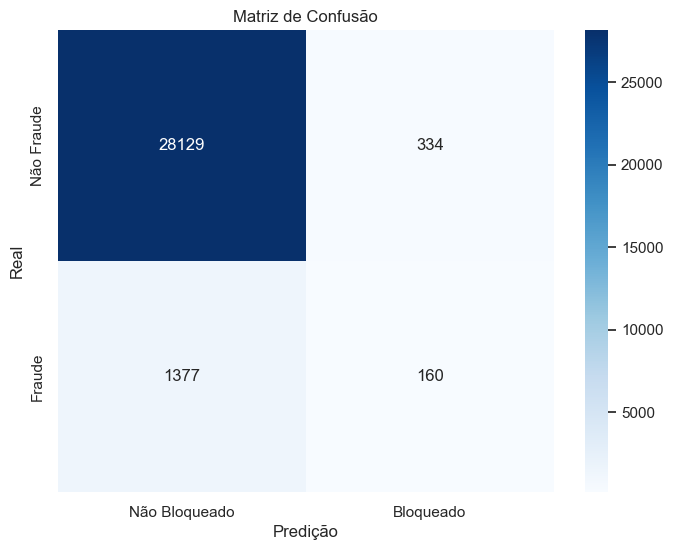

In [53]:
# criando coluna 'true labels'
true_labels = df_test[target_col]

# Criando a matriz de confusão
conf_matrix = confusion_matrix(true_labels, df_test_with_decision[blocked_col])

# Criando um heatmap para visualização
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Não Bloqueado", "Bloqueado"], yticklabels=["Não Fraude", "Fraude"])
plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [54]:
from sklearn.metrics import classification_report

# Calculando métricas usando sklearn's classification_report
report = classification_report(true_labels, df_test_with_decision[blocked_col], target_names=["Não Fraude", "Fraude"])

# Exibindo o relatório de classificação
print("Relatório de Classificação:")
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

  Não Fraude       0.95      0.99      0.97     28463
      Fraude       0.32      0.10      0.16      1537

    accuracy                           0.94     30000
   macro avg       0.64      0.55      0.56     30000
weighted avg       0.92      0.94      0.93     30000



In [55]:
# Calculando manualmente Recall (Sensibilidade), Precision e Especificidade
verdadeiros_positivos = conf_matrix[1, 1]
falsos_negativos = conf_matrix[1, 0]
falsos_positivos = conf_matrix[0, 1]
verdadeiros_negativos = conf_matrix[0, 0]

recall = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos) * 100
precision = verdadeiros_positivos / (verdadeiros_positivos + falsos_positivos) * 100
especificidade = verdadeiros_negativos / (verdadeiros_negativos + falsos_positivos) * 100

# Exibindo os resultados
print("Recall (Sensibilidade): {:.2f}%".format(recall))
print("Precision: {:.2f}%".format(precision))
print("Especificidade (Taxa de Aprovação): {:.2f}%".format(especificidade))

Recall (Sensibilidade): 10.41%
Precision: 32.39%
Especificidade (Taxa de Aprovação): 98.83%


In [56]:
# Calculando manualmente Recall (Sensibilidade), Precision, Especificidade e Taxa de Fraude
verdadeiros_positivos = conf_matrix[1, 1]
falsos_negativos = conf_matrix[1, 0]
falsos_positivos = conf_matrix[0, 1]
verdadeiros_negativos = conf_matrix[0, 0]

recall = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos) * 100
precision = verdadeiros_positivos / (verdadeiros_positivos + falsos_positivos) * 100
especificidade = verdadeiros_negativos / (verdadeiros_negativos + falsos_positivos) * 100
taxa_de_fraude = falsos_negativos / (falsos_negativos + verdadeiros_negativos) * 100
auc_roc = roc_auc_score(true_labels, df_test_with_decision[blocked_col])
f1 = f1_score(true_labels, df_test_with_decision[blocked_col])

# Exibindo os resultados
print("Recall (Sensibilidade): {:.2f}%".format(recall))
print("Precision: {:.2f}%".format(precision))
print("Especificidade (Taxa de Aprovação): {:.2f}%".format(especificidade))
print("Taxa de Fraude: {:.2f}%".format(taxa_de_fraude))
print("AUC-ROC Score: {:.2f}".format(auc_roc))
print("F1-score: {:.2f}".format(f1))

Recall (Sensibilidade): 10.41%
Precision: 32.39%
Especificidade (Taxa de Aprovação): 98.83%
Taxa de Fraude: 4.67%
AUC-ROC Score: 0.55
F1-score: 0.16


In [57]:
# fazendo uma cópia do dataset original, pois realizarei as modificações diretamente no dataset
df_copy = df.copy()

##### Tendo já realizado a análise do modelo atual, agora iremos começar o pré processamento para criarmos um novo modelo.

###### Pré- processamento dos dados

- Exclusão da coluna score_fraude_modelo, pois ela é o resultado do modelo atual

- Retirada da coluna data_compra para que o tempo não tenha efeito sobre o modelo

- na coluna entrega_doc_2 os valores nulos serão considerados como 0, como se não houvesse a entrega do documento

- Valores nulos serão preenchidos com a mediana (não são normais)

- Iremos utilizar apenas os dados provenientes dos dois países que contabilizam 80% das fraudes, Brasil e Argentina (BR e AR)

- one hot encoder nas variáveis categóricas

- target encoder em categoria_produto por conta da cardinalidade

In [58]:
# exclusão da coluna de colunas
df = df.drop(['score_fraude_modelo','data_compra', 'produto'], axis = 1)

In [59]:
# Preenchendo os valores nulos na coluna 'entrega_doc_2' com 0
df['entrega_doc_2'].fillna(0, inplace=True)


In [60]:
# preenchendo valores nulos com a mediana
df = df.fillna(df.median())

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   score_1            150000 non-null  int64  
 1   score_2            150000 non-null  float64
 2   score_3            150000 non-null  float64
 3   score_4            150000 non-null  float64
 4   score_5            150000 non-null  float64
 5   score_6            150000 non-null  float64
 6   pais               149806 non-null  object 
 7   score_7            150000 non-null  int64  
 8   categoria_produto  150000 non-null  object 
 9   score_8            150000 non-null  float64
 10  score_9            150000 non-null  float64
 11  score_10           150000 non-null  float64
 12  entrega_doc_1      150000 non-null  int64  
 13  entrega_doc_2      150000 non-null  object 
 14  entrega_doc_3      150000 non-null  object 
 15  valor_compra       150000 non-null  float64
 16  fr

In [62]:
# selecionando apenas os países BR e AR
# Identificando os países que contabilizam 80% das fraudes
fraud_by_country = df[df['fraude'] == 1].groupby('pais')['fraude'].count()
fraud_by_country_percentage = fraud_by_country / fraud_by_country.sum()

# Selecionando países que contabilizam 80% das fraudes
selected_countries = fraud_by_country_percentage[fraud_by_country_percentage.cumsum() <= 0.8].index

# Filtrar os dados apenas para esses países
df_selected_countries = df[df['pais'].isin(selected_countries)]

In [63]:
df_selected_countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31964 entries, 2 to 149993
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   score_1            31964 non-null  int64  
 1   score_2            31964 non-null  float64
 2   score_3            31964 non-null  float64
 3   score_4            31964 non-null  float64
 4   score_5            31964 non-null  float64
 5   score_6            31964 non-null  float64
 6   pais               31964 non-null  object 
 7   score_7            31964 non-null  int64  
 8   categoria_produto  31964 non-null  object 
 9   score_8            31964 non-null  float64
 10  score_9            31964 non-null  float64
 11  score_10           31964 non-null  float64
 12  entrega_doc_1      31964 non-null  int64  
 13  entrega_doc_2      31964 non-null  object 
 14  entrega_doc_3      31964 non-null  object 
 15  valor_compra       31964 non-null  float64
 16  fraude             31

In [81]:
# Substitua 'df' pelo seu DataFrame
colunas_onehot = ['score_1', 'pais', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']

# Converta as colunas para o tipo de dado string
df[colunas_onehot] = df[colunas_onehot].astype(str)

# Use get_dummies do pandas para codificar one-hot
df_encoded = pd.get_dummies(df, columns=colunas_onehot)

# Se desejar substituir as colunas originais pelos resultados codificados, faça:
# df = pd.get_dummies(df, columns=colunas_onehot)

# Verifique o DataFrame resultante
print(df_encoded.head())

   score_2    score_3  score_4   score_5  score_6  score_7 categoria_produto  \
0   0.7685   94436.24     20.0  0.444828      1.0        5       cat_8d714cd   
1   0.7550    9258.50      1.0  0.000000     33.0        0       cat_64b574b   
2   0.7455  242549.09      3.0  0.000000     19.0       23       cat_e9110c5   
3   0.7631   18923.90     50.0  0.482385     18.0       23       cat_d06e653   
4   0.7315    5728.68     15.0  0.000000      1.0        2       cat_6c4cfdc   

    score_8  score_9  score_10  ...  pais_UY  pais_ZA  pais_nan  \
0  0.883598    240.0     102.0  ...        0        0         0   
1  0.376019   4008.0       0.0  ...        0        0         0   
2  0.516368   1779.0      77.0  ...        0        0         0   
3  0.154036   1704.0    1147.0  ...        0        0         0   
4  0.855798   1025.0     150.0  ...        0        0         0   

   entrega_doc_1_0  entrega_doc_1_1  entrega_doc_2_0  entrega_doc_2_N  \
0                0                1        

In [67]:
# Criando uma instância do TargetEncoder
target_encoder = ce.TargetEncoder(cols=['categoria_produto'])

# Ajustando o encoder ao DataFrame original
df_encoded = target_encoder.fit_transform(df_selected_countries, df_selected_countries['fraude'])

In [68]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31964 entries, 2 to 149993
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   score_1            31964 non-null  int64  
 1   score_2            31964 non-null  float64
 2   score_3            31964 non-null  float64
 3   score_4            31964 non-null  float64
 4   score_5            31964 non-null  float64
 5   score_6            31964 non-null  float64
 6   pais               31964 non-null  object 
 7   score_7            31964 non-null  int64  
 8   categoria_produto  31964 non-null  float64
 9   score_8            31964 non-null  float64
 10  score_9            31964 non-null  float64
 11  score_10           31964 non-null  float64
 12  entrega_doc_1      31964 non-null  int64  
 13  entrega_doc_2      31964 non-null  object 
 14  entrega_doc_3      31964 non-null  object 
 15  valor_compra       31964 non-null  float64
 16  fraude             31